# **Chapter 9 추천 시스템**

### **[개념 정리]**

#### **07 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**

행렬 분해 잠재 요인 협업 필터링
> SVD나 NMF 등 적용 가능

사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 Null 데이터가 많음
> 주로 SGD나 ALS 기반의 행렬 분해 이용

#### **08 파이썬 추천 시스템 패키지 一 Surprise**

##### **Surprise를 이용한 추천 시스템 구축**

Surprise는 무비렌즈(MovieLens) 사이트에서 제공하는 과거 버전의 데이터 세트를 가져오는 API를 제공
-  파이썬 기반의 추천 시스템 구축을 위한 전용 패키지 중의 하나
-  사이킷런은 추천 천용 모듈을 제공하지 않음

##### **Surprise 주요 모듈 소개**

userjd（사용자 아이디）, item_id（아이템 아이디）, rating（평점） 데이터가 로우 레벨로 된 데이터 세트만 적용 가능
- 데이터의 첫 번째 칼럼을 사용자 아이디, 두 번째 칼럼을 아이템 아이디, 세 번째 칼럼을 평점으로 가정해 데이터를 로딩하고 네 번째 칼럼부터는 아예 로딩을 수행하지 않음

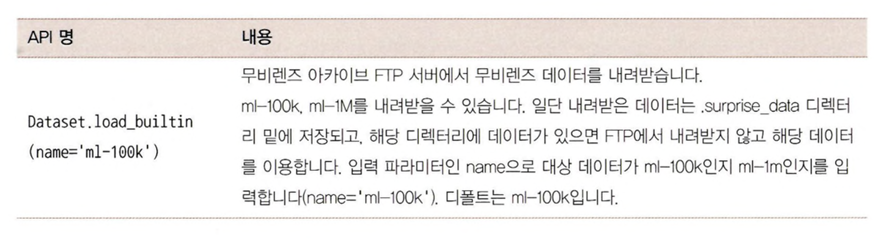
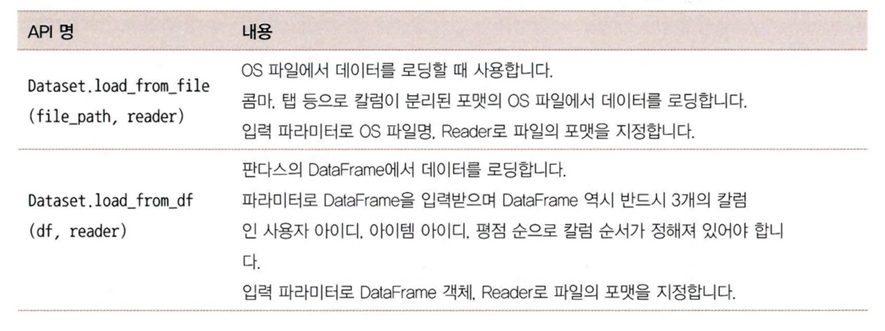

##### **Surprise 추천 알고리즘 클래스**

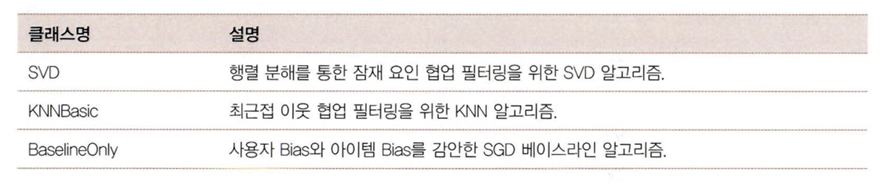

Surprise SVD
- 비용 함수 --> 사용자 베이스라인(Baseline) 편향성을 감안한 평점 예측에 Regularization을 적용한 것
- SVD 클래스의 입력 파라미터 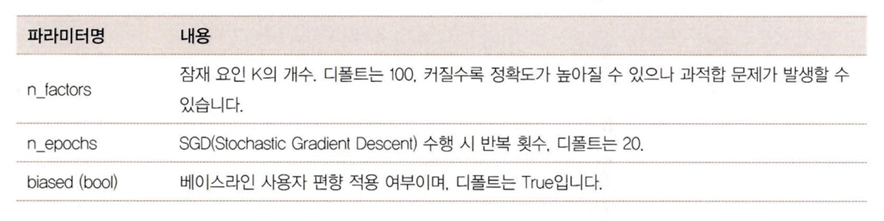

##### **베이스라인 평점**

베이스라인 평점(Baseline Rating)
> 개인의 성향을 반영해 아이템 평가에 편향성(bias) 요소를 반영하여 평점을 부과하는 것
> - 보통 베이스라인 평점은 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수 공식으로 계산 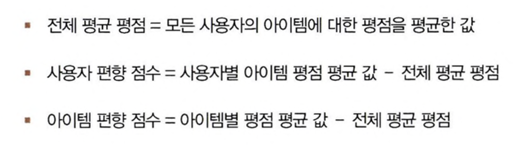

##### **교차 검증과 하이퍼 파라미터 튜닝**

사이킷런과 유사한 cross_validate( )와 GridSearchCV 클래스를 제공

### **[필사]**

#### **07 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**

In [7]:
from sklearn.metrics import mean_squared_error

def get_rmse(R,P,Q,non_zeros):
  error=0
  # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_metrix = np.dot(P,Q.T)

  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스를 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_metrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

In [9]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):
  num_users, num_items = R.shape
  #P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤한 값으로 입력합니다.
  np.random.seed(1)
  P=np.random.normal(scale=1./K, size=(num_users, K))
  Q=np.random.normal(scale=1./K, size=(num_items, K))

  # R>0인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
  non_zeros = [(i,j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i, j]>0]

  # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트.
  for step in range(steps):
    for i,j, r in non_zeros:
      # 실제 값과 예측 값의 차이인 오류 값 구함
      eij = r-np.dot(P[i,:], Q[j,:].T)
      # Regularization을 반영한 SGD 업데이트 공식 적용
      P[i,:] = P[i,:] + learning_rate*(eij*Q[j,:] - r_lambda*P[i,:])
      Q[j,:] = Q[j,:] + learning_rate*(eij*P[i,:] - r_lambda*Q[j,:])

    rmse = get_rmse(R, P, Q, non_zeros)
    if(step % 10) ==0:
      print("### iteration step: ",step, "rmse:", rmse)

  return P, Q

In [15]:
# 영화 평점 행렬 데이터를 새롭게 DataFrame으로 로딩 후 다시 사용자-아이템 평점 행렬로 생성
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns = 'movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 pivot 수행.
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [17]:
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda=0.01)
pred_matrix = np.dot(P,Q.T)

### iteration step:  0 rmse: 2.9023619751336867
### iteration step:  10 rmse: 0.7335768591017927
### iteration step:  20 rmse: 0.5115539026853442
### iteration step:  30 rmse: 0.37261628282537446
### iteration step:  40 rmse: 0.2960818299181014
### iteration step:  50 rmse: 0.2520353192341642
### iteration step:  60 rmse: 0.22487503275269854
### iteration step:  70 rmse: 0.20685455302331537
### iteration step:  80 rmse: 0.19413418783028685
### iteration step:  90 rmse: 0.18470082002720403
### iteration step:  100 rmse: 0.17742927527209104
### iteration step:  110 rmse: 0.17165226964707486
### iteration step:  120 rmse: 0.1669518194687172
### iteration step:  130 rmse: 0.16305292191997542
### iteration step:  140 rmse: 0.15976691929679643
### iteration step:  150 rmse: 0.1569598699945732
### iteration step:  160 rmse: 0.15453398186715428
### iteration step:  170 rmse: 0.15241618551077643
### iteration step:  180 rmse: 0.15055080739628307
### iteration step:  190 rmse: 0.1488947091323209

In [18]:
# 반환된 예측 사용자-아이템 평점 행렬을 영화 타이틀을 칼럼명으로 가지는 데이터프레임으로 변경
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [19]:
def get_unseen_movies(ratings_matrix, userId):
  #userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임.
  user_rating = ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦.
  already_seen = user_rating[user_rating >0].index.tolist()

  # 모든 영화명을 list 객체로 만듦.
  movies_list = ratings_matrix.columns.tolist()

  # list comprehension 으로 already_seen에 해당하는 영화는 movies_list에서 제외함.
  unseen_list = [movie for movie in movies_list if movie not in already_seen]

  return unseen_list

In [20]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
  # 예측 평점 DataFrame에서 사용자 id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
  # 가장 예측 평점이 높은 순으로 정렬함.
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
  return recomm_movies

In [21]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index, columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


#### **08 파이썬 추천 시스템 패키지 一 Surprise**

In [27]:
!pip install scikit-surprise

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-win_amd64.whl size=1292100 sha256=58579bdbf06ed8a4eb28703b7eb17db83ff0bfc746872c49e6a7791415df46a7
  Stored in directory: c:\users\won-0\appdata\local\pip\cache\wheels\75\fa\bc\739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [28]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [29]:
# 추천을 위한 데이터 세트를 로딩
data = Dataset.load_builtin('ml-100k')
# 수행 시 마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 

 Y


Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to C:\Users\won-0/.surprise_data/ml-100k


In [30]:
# SVD로 잠재 요인 협업 필터링을 수행
algo = SVD(random_state=0)
# fit을 이용해 학습 데이터 세트 기반으로 추천 알고리즘을 학습
algo.fit(trainset)

In [31]:
# 학습된 추천 알고리즘을 기반으로 테스트 데이터 세트에 대해 추천을 수행
predictions = algo.test(testset)
print('prediction type: ', type(predictions), 'size: ', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type:  <class 'list'> size:  25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

In [32]:
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

In [33]:
# surprise 패키지의 다른 추천 예측 메서드인 predict()를 이용해 추천 예측을 진행
# 사용자 아이디, 아이템 아이디 문자열로 입력해야 함.
uid = str(196)
iid = str(302)
pred = algo.predict(uid,iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


In [34]:
# 테스트 데이터 세트를 이용해 추천 예측 평점과 실제 평점과의 차이를 평가
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

##### **Surprise 주요 모듈 소개**

OS 파일 데이터를 Surprise 데이터 세트로 로딩

In [61]:
import pandas as pd
ratings = pd.read_csv('ratings.csv')
# ratings_noh.csv 파일로 업로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성.
ratings.to_csv('ratings_noh.csv', index=False, header=False)

In [63]:
from surprise import Reader

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5,5))
data=Dataset.load_from_file('ratings_noh.csv', reader=reader)

In [65]:
# SVD 행렬 분해 기법을 이용하여 추천을 예측
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

판다스 DataFrame에서 Surprise 데이터 세트로 로딩

In [69]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

##### **교차 검증과 하이퍼 파라미터 튜닝**

In [75]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('ratings.csv') # reading data in pandas df
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId','rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8688  0.8809  0.8679  0.8758  0.8726  0.8732  0.0048  
MAE (testset)     0.6697  0.6765  0.6686  0.6715  0.6695  0.6712  0.0028  
Fit time          0.93    0.95    0.96    0.85    0.98    0.93    0.05    
Test time         0.07    0.09    0.08    0.08    0.08    0.08    0.00    


{'test_rmse': array([0.86875695, 0.88092589, 0.86790862, 0.87578182, 0.87258328]),
 'test_mae': array([0.66974362, 0.67645239, 0.66859186, 0.67147973, 0.6695167 ]),
 'fit_time': (0.9328713417053223,
  0.9546828269958496,
  0.9585504531860352,
  0.8462438583374023,
  0.9811828136444092),
 'test_time': (0.0730290412902832,
  0.08593511581420898,
  0.0770561695098877,
  0.08101320266723633,
  0.08246779441833496)}

In [77]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정.
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도로 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8776388808022743
{'n_epochs': 20, 'n_factors': 50}


In [78]:
# 다음 코드는 train_test_split()으로 분리되지 않는 데이터 세트에 fit()을 호출해 오류가 발생합니다.
data= Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'